# Plot surface tension

### Initialize 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import signac
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set(style='ticks', palette='Set2', font_scale=2)
sns.despine()
import numpy as np

project = signac.contrib.get_project()

### Select data

In [2]:
surfactant = 'c12e8'
solvents = ['branched_c11','water_SPC']

### Collect data

In [3]:
matching_jobs = set([job for job in project.find_jobs({'type':'tension'})
        if job.statepoint()['surfactant'] == surfactant
        and job.statepoint()['solvents'] == list(solvents)])

if not matching_jobs:
    print('Found no matching jobs')
    
finished_jobs = set([job for job in matching_jobs if 'stage' in job.document and (job.document['stage'] == 'finished' or job.document['run_count'] > 0)])
ready_jobs = set([job for job in matching_jobs-finished_jobs if 'stage' in job.document and job.document['stage'] == 'ready'])
computed_jobs = set([job for job in finished_jobs if 'st_avg' in job.document])

if ready_jobs:
    print('Matching jobs that are ready but not run:')
for job in (ready_jobs):
    print(job.get_id())
    print(job.statepoint())
    print('')

if computed_jobs:
    print('Matching jobs that have been post-processed:')
    for job in (computed_jobs):
        print(job.get_id())
        print(job.statepoint())
        print('')
else:
    print('Found no post-processed jobs')

good_jobs = [job for job in computed_jobs if job.document['desorbed'] == False]
desorbed_jobs = [job for job in computed_jobs if job.document['desorbed'] == True]

area = []
avg = []
stderr = []
for job in good_jobs:
    area.append(float(job.statepoint()['xy_len']**2)/float(job.statepoint()['N']))
    avg.append(job.document['st_avg'])
    stderr.append(job.document['st_stderr'])

area_des = []
avg_des = []
stderr_des = []
for job in desorbed_jobs:
    area_des.append(float(job.statepoint()['xy_len']**2)/float(job.statepoint()['N']))
    avg_des.append(job.document['st_avg'])
    stderr_des.append(job.document['st_stderr'])

def onpick3(event):
        ind = event.ind
        if ind < len(good_jobs):
            picked_job = good_jobs[ind]
        else:
            picked_job = desorbed_jobs[ind - len(good_jobs)]
        print(picked_job.get_id())
        print(picked_job.statepoint())

Matching jobs that have been post-processed:
bb031232aa427d9aae47bc4455cf9081
{u'surfactant': u'c12e8', u'slab_thicknesses': [10, 10], u'Pz': 1.0, u'N': 10, u'solvents': [u'branched_c11', u'water_SPC'], u'T': 300.0, u'type': u'tension', u'forcefield': u'gromos53a6oxy+D', u'xy_len': 6}

3159f05960f1d939ec6fed5c08488160
{u'surfactant': u'c12e8', u'slab_thicknesses': [10, 10], u'Pz': 1.0, u'N': 31, u'solvents': [u'branched_c11', u'water_SPC'], u'T': 300.0, u'type': u'tension', u'forcefield': u'gromos53a6oxy+D', u'xy_len': 6}

d604e5bcaeabeeb4a8bfc833a73de3e5
{u'surfactant': u'c12e8', u'slab_thicknesses': [10, 10], u'Pz': 1.0, u'N': 67, u'solvents': [u'branched_c11', u'water_SPC'], u'T': 300.0, u'xy_len': 6, u'type': u'tension', u'forcefield': u'gromos53a6oxy+D'}

c971c4952ae01992eaa000b5f849a1b2
{u'surfactant': u'c12e8', u'slab_thicknesses': [10, 10], u'Pz': 1.0, u'N': 52, u'solvents': [u'branched_c11', u'water_SPC'], u'T': 300.0, u'type': u'tension', u'forcefield': u'gromos53a6oxy+D', u'

### Plot data

In [4]:
%matplotlib notebook
fig, ax = plt.subplots()
scatter = plt.errorbar(area, avg, yerr=stderr, fmt='bo', picker=True)[2]
labels = [str(a) for a in area]
if desorbed_jobs:
    plt.errorbar(area_des, avg_des, yerr=stderr_des, fmt='ro', picker=True)
plt.xlim([0,10])
plt.xlabel('Area per molecule (nm$^2$)')
plt.ylabel('Surface tension (mN/m)')
fig.canvas.mpl_connect('pick_event', onpick3)
plt.gcf().subplots_adjust(left=0.15)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('st.pdf')
plt.show()

<IPython.core.display.Javascript object>

In [5]:
def plot_isotherm(a, p50, p5, p95, color='b'):
    plt.fill_between(a, p5, p95, color=color, alpha=0.3)
    plt.plot(a, p50, '{}-'.format(color))

def plot_mepaw(a, p, color='b'):
    dpda = np.gradient(p.T, np.gradient(a), axis=1)
    deltamu = scipy.integrate.cumtrapz(
        ((dpda/kT+1./a**2.)*a)[:, ::-1], a[::-1], initial=0)[:, ::-1]

    p_vdw = kT/(a[a>2.]-2.).reshape(len(a[a>2.]), 1)
    dpda_vdw = np.gradient(p_vdw.T, np.gradient(a[a>2.]), axis=1)
    deltamu_vdw = scipy.integrate.cumtrapz(
        ((dpda_vdw/kT+1./a[a>2.]**2.)*a[a>2.])[:, ::-1], a[a>2.][::-1], initial=0)[:, ::-1]

    dm5 = np.percentile(deltamu, 5, axis=0)
    dm95 = np.percentile(deltamu, 95, axis=0)
    dm50 = np.percentile(deltamu, 50, axis=0)

    plt.fill_between(a, dm5, dm95, color=color, alpha=0.3)
    plt.plot(a, dm50, '{}-'.format(color))

<IPython.core.display.Javascript object>


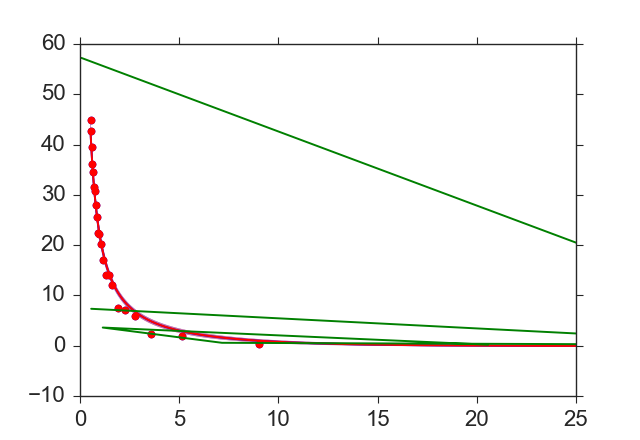

<IPython.core.display.Javascript object>

In [126]:
import scipy
from surfacepressure_GP import fit_gpy

kT = 4.14195
a_1, p50_1, p5_1, p95_1, p_1 = fit_gpy(np.array(area),
                                       51.-np.array(avg),
                                       a_ideal=8., kT=kT, x_max=0.9999999)

a_2, p50_2, p5_2, p95_2, p_2 = fit_gpy(np.array(area),
                                       51.-np.array(avg),
                                       a_ideal=8., kT=kT, x_max=0.9999999)

plt.figure()
plot_isotherm(a_1, p50_1, p5_1, p95_1, 'b')
plt.plot(area, 50.-np.array(avg), 'bo')

plot_isotherm(a_2, p50_2, p5_2, p95_2, 'r')
plt.plot(area, 50.-np.array(avg), 'ro')
plt.xlim([0, 25.])

plt.plot(a, kT/a, 'g-')

plt.figure()
plot_mepaw(a_1, p_1, 'b')
plot_mepaw(a_2, p_2, 'r')
plt.plot([0.73469, 0.5625, 0.6207], [-15.353+24.51, -13.75+24.51, -14.408+24.51], '.')


In [8]:
from surfacepressure import Fit_vdW_SoE_vdW

y = Fit_vdW_SoE_vdW(np.array(area), 51.-np.array(avg))

In [112]:
from scipy.optimize import differential_evolution
from diffevol import ExpFitDiffEvol, EvalExpFit

def f_exp(x, fi, taui, vdwa):
    return np.dot(fi, np.exp(-np.outer(1./taui, x)))
        
def f_vdw(x, fi, taui, vdwa):
    return kT/(x-vdwa)

def f_piecewise(x, fi, taui, switch, vdwa):
    return np.piecewise(x, [x < switch, x >= switch], [f_exp, f_vdw], fi, taui, vdwa)

def blah(N, x, y):
    """Fit N-exponential decay to a dataseries (x, y) using differential
    evolution as implemented in scipy.optimize.

    Parameters
    ----------
    N : float
        number of summed exponentials to fit

    x : array
        x values

    y : array
        y values

        returns a, b
        len(a) = N
        len(b) = N

        y(x) = \sum_{i=1}^N a_i \exp ( - b_i x )

        Use of differntial evolution inspired by use of another genetic algorithm
        to perform exponential fit of by Weizhong Zou in
            
            Zou, Weizhong. Larson, Ronald G.
            "A mesoscopic simulation method for predicting the rheology of
            semi-dilute wormlike micellar solutions." Journal of Rheology. 58,
            681 (2014).

    """
    x = np.array(x)
    y = np.array(y)

    # tau_i (1/b_i), a_i, switch, vdwa_by_switch
    bounds = [[max(min(y), 0), max(y)]]*N + [[min(x), max(x)]]*N + [[min(x), max(x)*2.]] + [[0., 1.]]

    def objective(s):
        fi, taui = np.split(s[:-2], 2)
        switch = s[-2]
        vdwa_by_switch = s[-1]
        
        return np.sum((y - f_piecewise(x, fi, taui, switch, vdwa_by_switch*switch))**2.\
                + 0.1*(f_vdw(switch, fi, taui, vdwa_by_switch*switch)\
                   - f_exp(switch, fi, taui, vdwa_by_switch*switch))**2.)

    result = differential_evolution(objective, bounds)
    s = result['x']
    fi, taui = np.split(s[:-2], 2)
    switch = s[-2]
    vdwa = s[-1]
    return fi, taui, switch, vdwa        

In [115]:
switch

59.423293558137637

In [132]:
a, b, switch, vdwa_by_switch = blah(8, area, 50.-np.array(avg))

In [ ]:
a,b = ExpFitDiffEvol(8, area, 51.-np.array(avg))

<IPython.core.display.Javascript object>


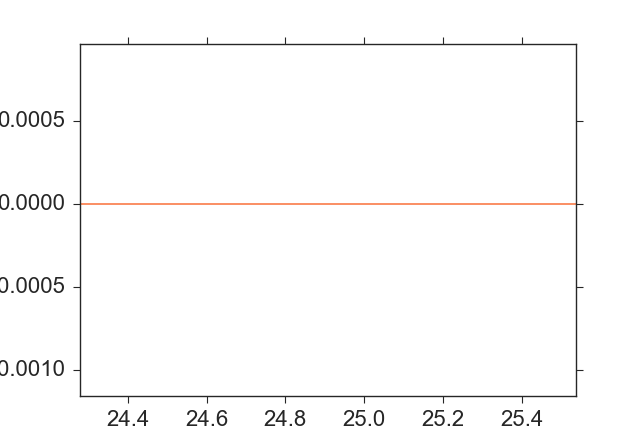

In [86]:
plt.figure()
plt.plot(area, 51.-np.array(avg), 'o')
x = np.linspace(min(area), max(area), 1000)
plt.plot(x, EvalExpFit(x, a, b), '-')

<IPython.core.display.Javascript object>


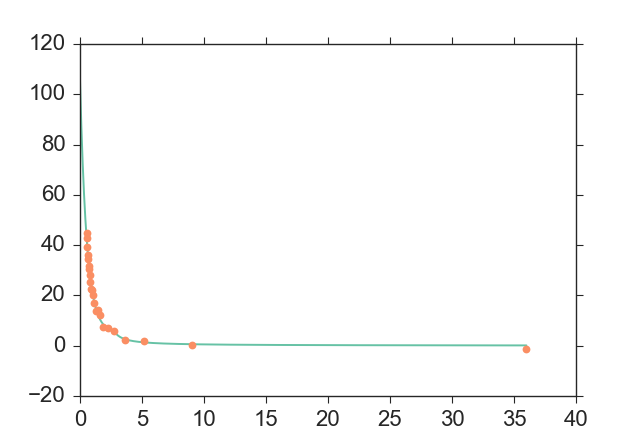

In [130]:
plt.figure()
x = np.linspace(0., max(area), 1000)
plt.plot(x, f_piecewise(x, a, b, switch, vdwa_by_switch*switch), '-')
plt.plot(area, 50.-np.array(avg), 'o')

In [116]:
print(a)
print(b)
print(switch)
print(vdwa_by_switch*switch)

[ 20.57251926   1.14648695   7.157913    38.83938881   0.07237268   0.
   0.56410023  36.56775907]
[  0.53731343   5.34674744   5.16208119   0.53731343   4.70028689
  20.52682329   5.43515072   0.53731343]
59.4232935581
0.0


In [ ]:
from surfacepressure import Fit_vdW_SoE_vdW

y = Fit_vdW_SoE_vdW(np.array(area), 51.-np.array(avg))

<IPython.core.display.Javascript object>


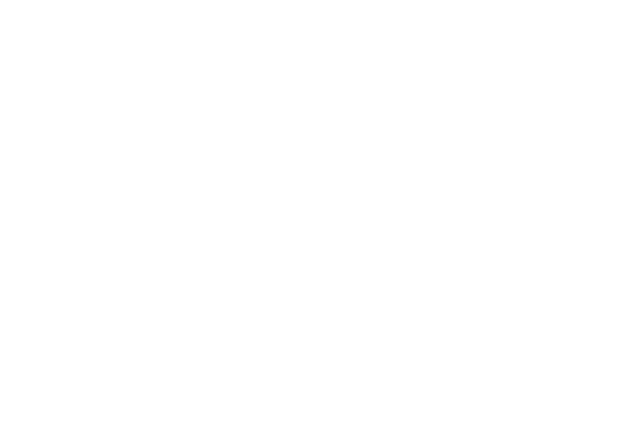

AttributeError: 'numpy.ndarray' object has no attribute 'Pi'

In [131]:
plt.figure()
plt.plot(area, y.Pi(area), '.')
plt.plot(area, 51.5-np.array(avg), 'o')
#plt.plot(area, kT/np.array(area), 'o')

In [13]:
y.Pi.function_pieces

[<function surfacepressure.vdW_Pi>, <function surfacepressure.SoE_Pi>]

In [129]:
y = f_piecewise(x, a, b, switch, vdwa_by_switch*switch)
plt.figure()
plot_mepaw(x, f_piecewise(x, a, b, switch, vdwa_by_switch*switch).reshape(len(y),1))
plt.plot([0.73469, 0.5625, 0.6207], [-15.353+24.51, -13.75+24.51, -14.408+24.51], '.')

<IPython.core.display.Javascript object>